In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN
from qiskit import IBMQ

#time
import timeit


In [2]:
# network args
n_classes = 3
n_qubits = 4
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" # will run that name from qnetwork classes

# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector")) # Hybrid QNN
#qi = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed) # QSVM                                      


In [3]:
# train args
batch_size = 1
epochs = 5
LR = 0.0001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = 16
# dataset args
shuffle = True
dataset = "CIFAR10" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ["cat","dog",'bird'] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['cat', 'dog', 'bird']


In [4]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [5]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.00016461685299873352 s


<Figure size 432x288 with 0 Axes>

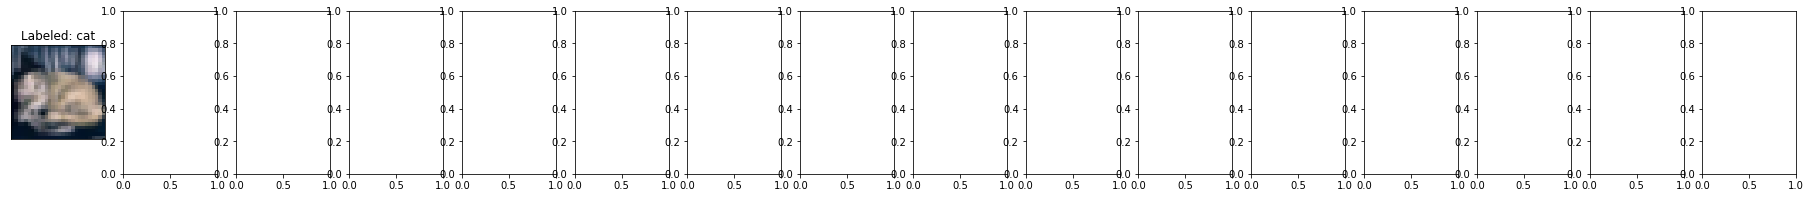

<Figure size 432x288 with 0 Axes>

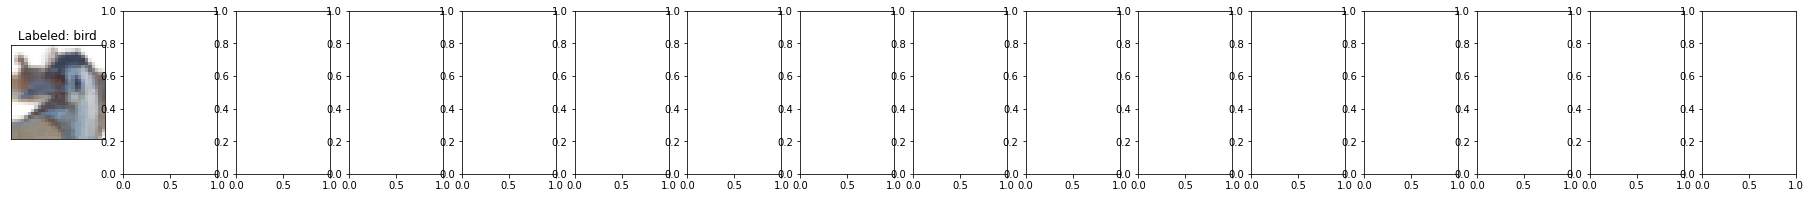

<Figure size 432x288 with 0 Axes>

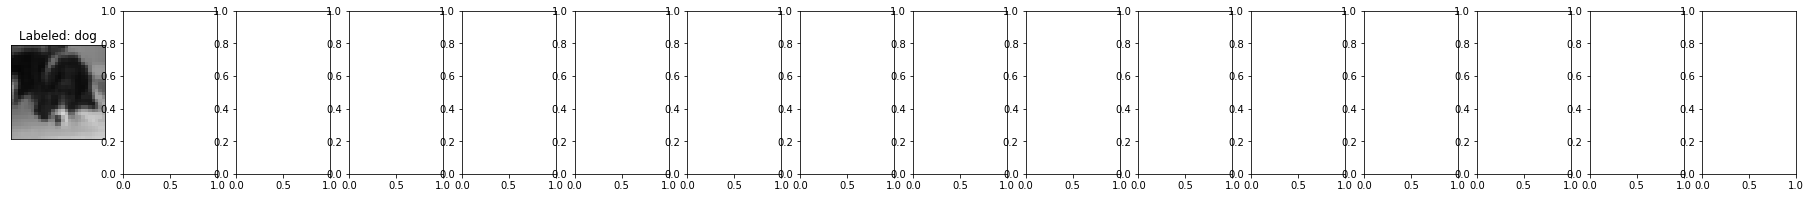

<Figure size 432x288 with 0 Axes>

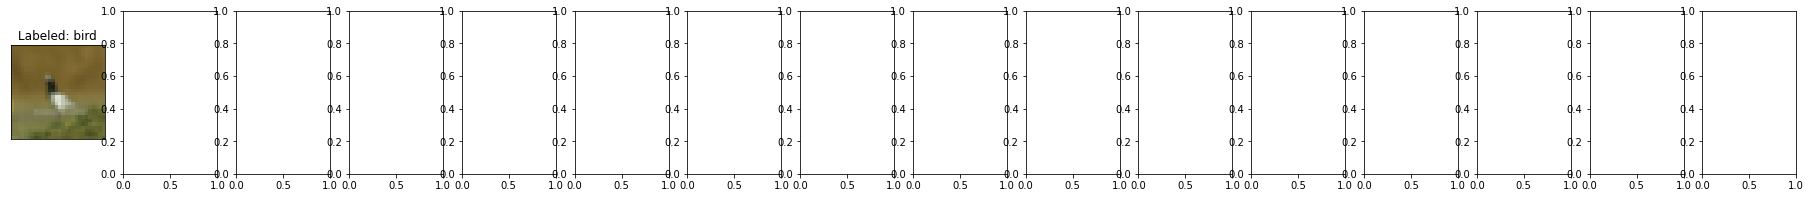

<Figure size 432x288 with 0 Axes>

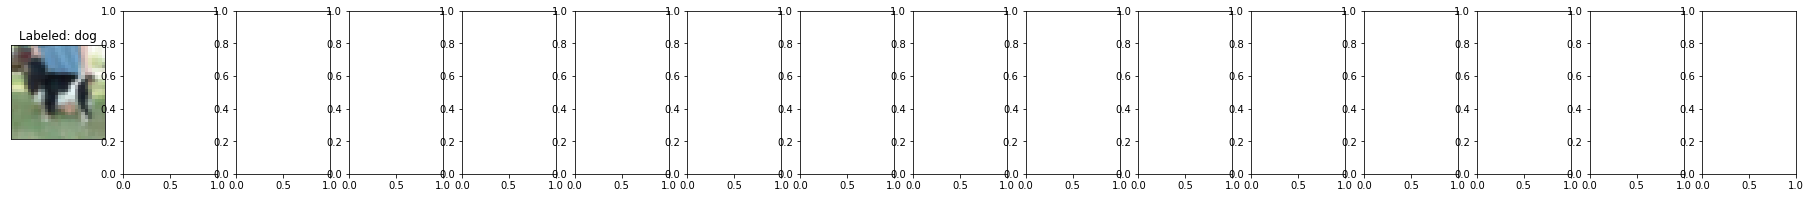

<Figure size 432x288 with 0 Axes>

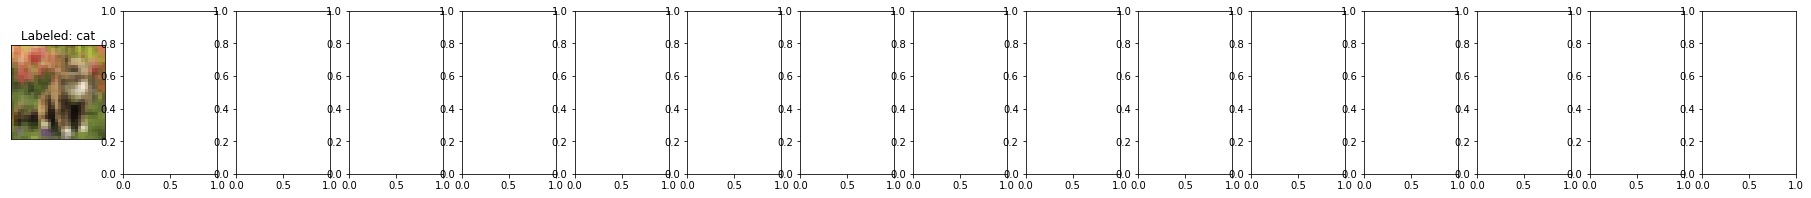

<Figure size 432x288 with 0 Axes>

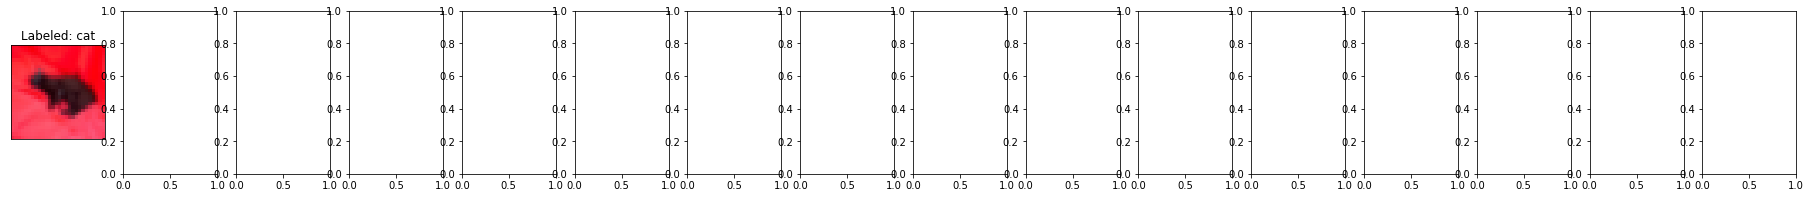

<Figure size 432x288 with 0 Axes>

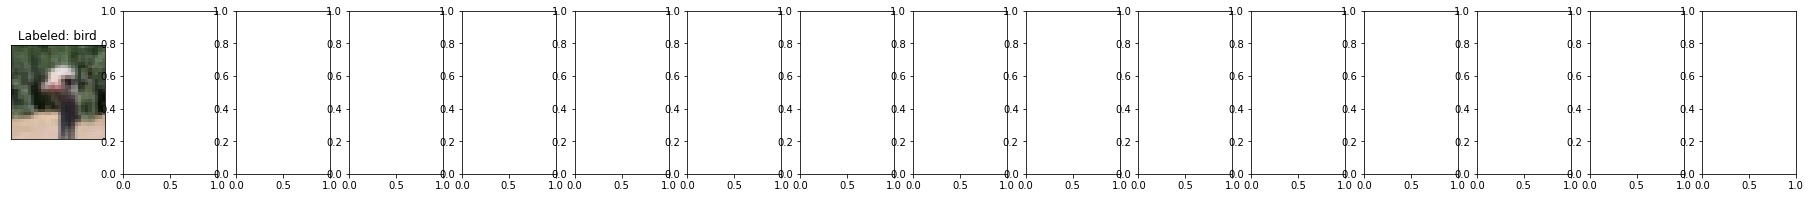

<Figure size 432x288 with 0 Axes>

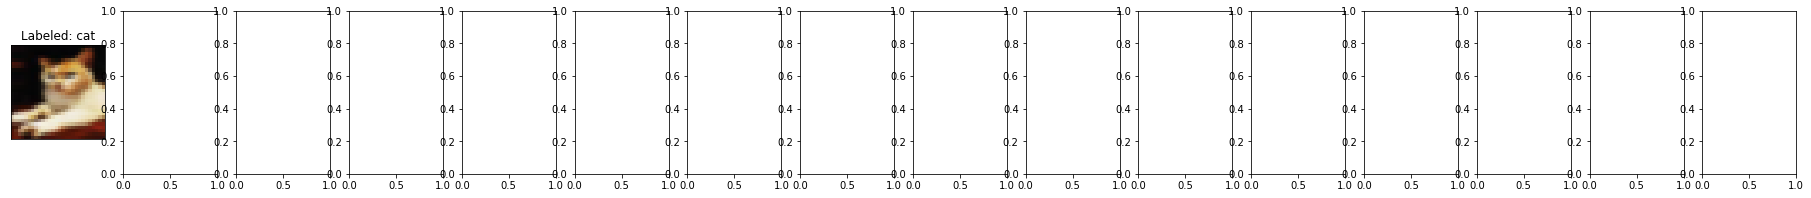

<Figure size 432x288 with 0 Axes>

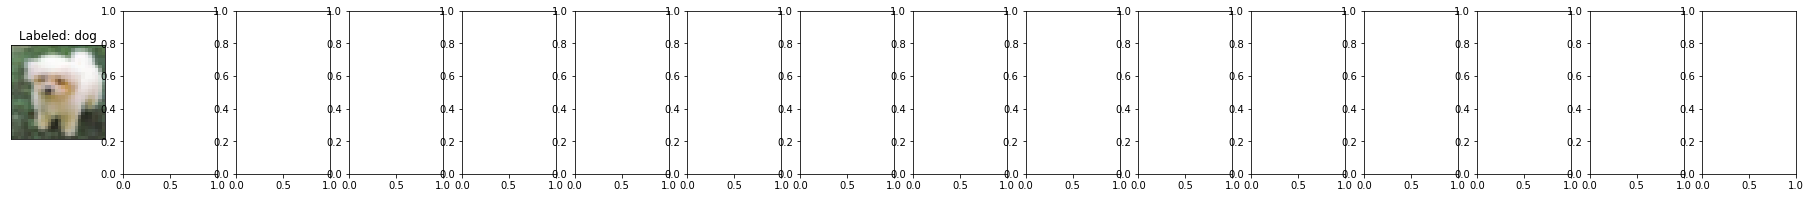

<Figure size 432x288 with 0 Axes>

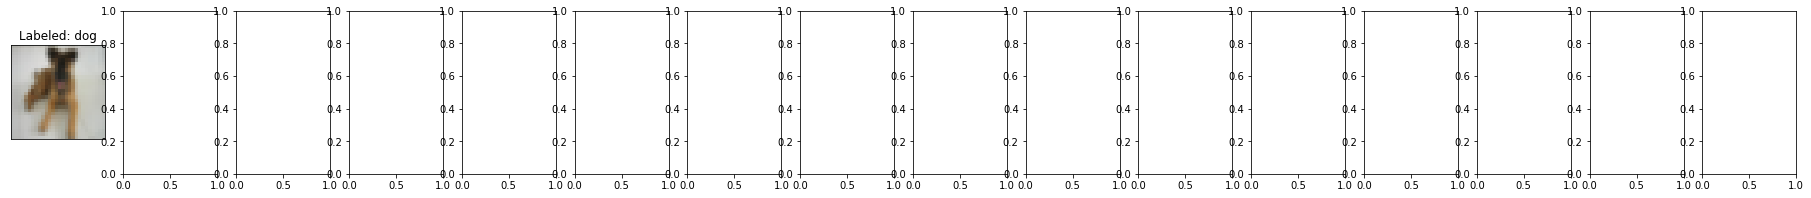

<Figure size 432x288 with 0 Axes>

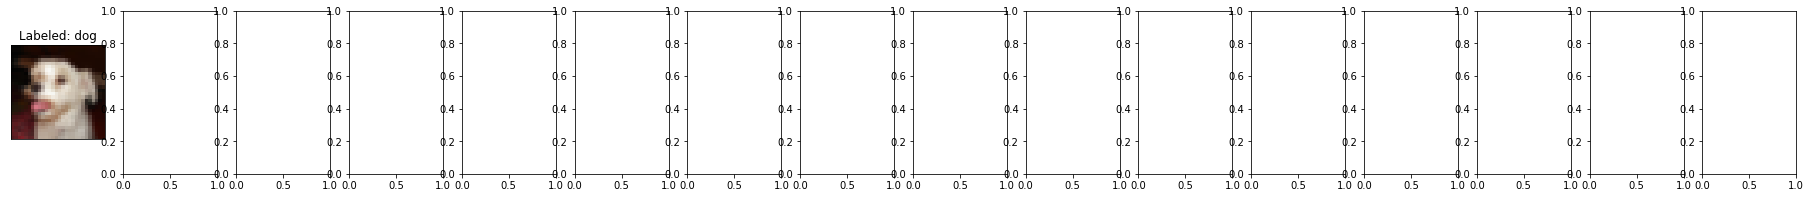

<Figure size 432x288 with 0 Axes>

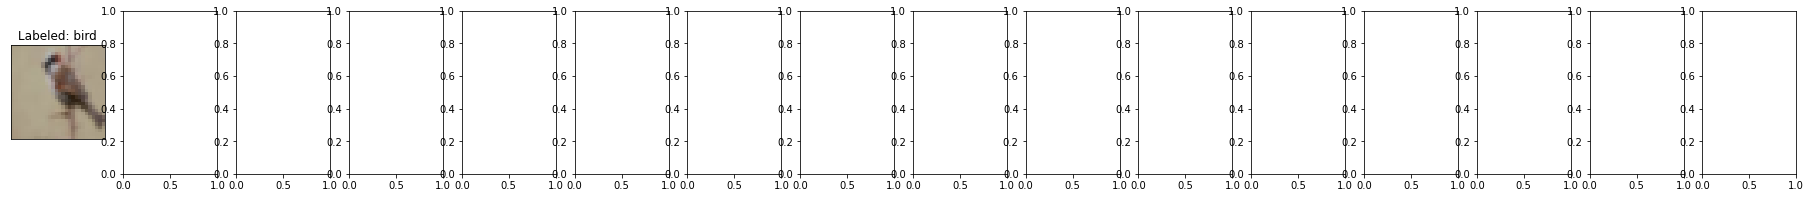

<Figure size 432x288 with 0 Axes>

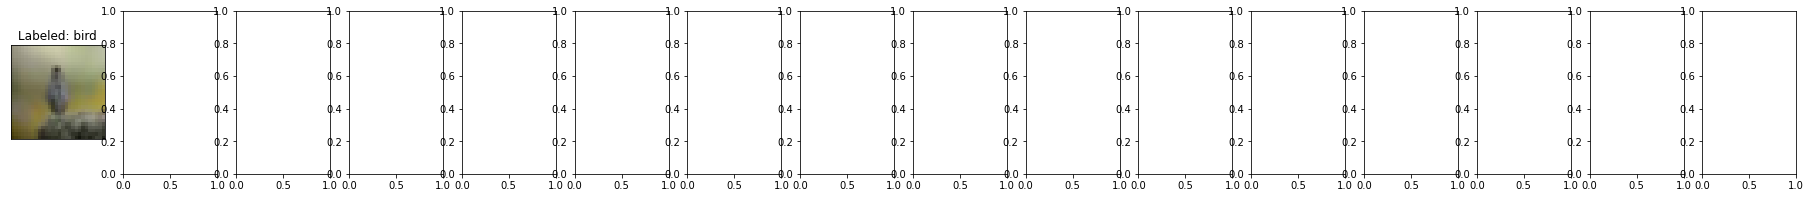

<Figure size 432x288 with 0 Axes>

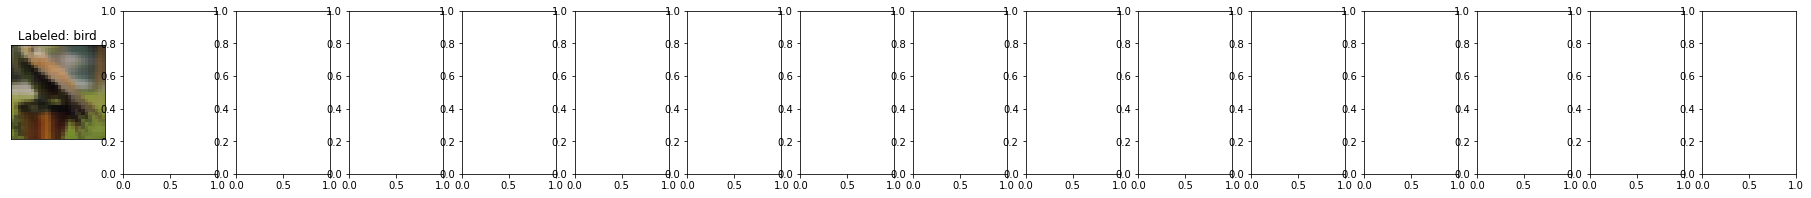

<Figure size 432x288 with 0 Axes>

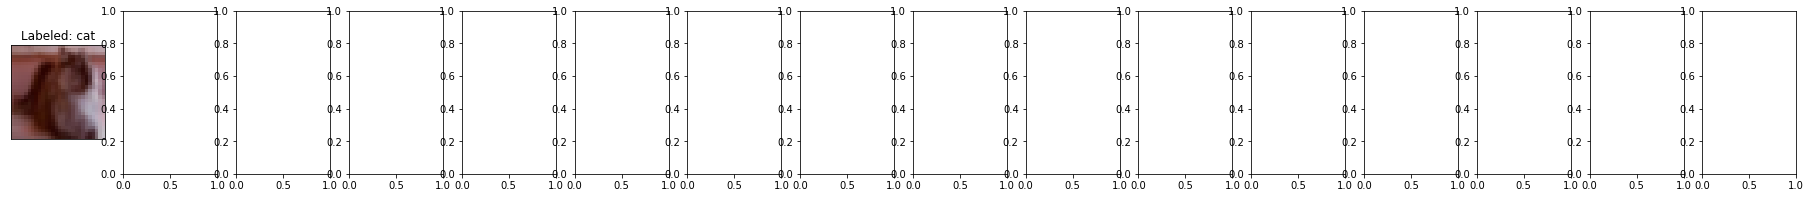

In [6]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [7]:
##### DESIGN NETWORK
time_start = timeit.timeit()

# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZZZ),
  CircuitStateFn(
       ┌────────────────────────────────────┐»
  q_0: ┤0                                   ├»
       │                                    │»
  q_1: ┤1                                   ├»
       │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
  q_2: ┤2                                   ├»
       │                                    │»
  q_3: ┤3                                   ├»
       └────────────────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │                                                          │
  «q_1: ┤1                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_2: ┤2                                                         ├
  «     │                                                          │
  «q_3: ┤3                  

In [ ]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            print(target)
            print(output)
            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(qi)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

tensor([1])
tensor([[ 0.2600,  0.5330, -1.1819]], grad_fn=<AddmmBackward0>)
Batch 0, Loss: -0.533022940158844
tensor([2])
tensor([[ 0.2802,  0.5216, -1.1533]], grad_fn=<AddmmBackward0>)
Batch 1, Loss: 1.153252363204956
tensor([2])
tensor([[ 0.2748,  0.5248, -1.1608]], grad_fn=<AddmmBackward0>)
Batch 2, Loss: 1.160832405090332
tensor([1])
tensor([[ 0.2939,  0.5140, -1.1337]], grad_fn=<AddmmBackward0>)
Batch 3, Loss: -0.5139763951301575
tensor([1])
tensor([[ 0.2650,  0.5305, -1.1745]], grad_fn=<AddmmBackward0>)
Batch 4, Loss: -0.530538022518158
tensor([0])
tensor([[ 0.3149,  0.5022, -1.1039]], grad_fn=<AddmmBackward0>)
Batch 5, Loss: -0.31487566232681274
tensor([0])
tensor([[ 0.3122,  0.5039, -1.1078]], grad_fn=<AddmmBackward0>)
Batch 6, Loss: -0.3121533691883087
tensor([0])
tensor([[ 0.2887,  0.5174, -1.1410]], grad_fn=<AddmmBackward0>)
Batch 7, Loss: -0.28869718313217163
tensor([0])
tensor([[ 0.3736,  0.4691, -1.0211]], grad_fn=<AddmmBackward0>)
Batch 8, Loss: -0.3735761046409607
tenso

Batch 73, Loss: -0.37276196479797363
tensor([0])
tensor([[ 0.4778,  0.4153, -0.8749]], grad_fn=<AddmmBackward0>)
Batch 74, Loss: -0.47783541679382324
tensor([0])
tensor([[ 0.4097,  0.4545, -0.9713]], grad_fn=<AddmmBackward0>)
Batch 75, Loss: -0.4096969664096832
tensor([2])
tensor([[ 0.3585,  0.4840, -1.0438]], grad_fn=<AddmmBackward0>)
Batch 76, Loss: 1.043819546699524
tensor([2])
tensor([[ 0.5406,  0.3795, -0.7861]], grad_fn=<AddmmBackward0>)
Batch 77, Loss: 0.7861318588256836
tensor([2])
tensor([[ 0.5611,  0.3678, -0.7572]], grad_fn=<AddmmBackward0>)
Batch 78, Loss: 0.7572135925292969
tensor([0])
tensor([[ 0.4440,  0.4352, -0.9228]], grad_fn=<AddmmBackward0>)
Batch 79, Loss: -0.44402727484703064
tensor([2])
tensor([[ 0.5432,  0.3783, -0.7826]], grad_fn=<AddmmBackward0>)
Batch 80, Loss: 0.7826038002967834
tensor([0])
tensor([[ 0.4572,  0.4277, -0.9042]], grad_fn=<AddmmBackward0>)
Batch 81, Loss: -0.45720547437667847
tensor([1])
tensor([[ 0.5868,  0.3534, -0.7208]], grad_fn=<AddmmBackw

Batch 146, Loss: -0.3554653525352478
tensor([2])
tensor([[ 0.5411,  0.3857, -0.7857]], grad_fn=<AddmmBackward0>)
Batch 147, Loss: 0.7857030034065247
tensor([2])
tensor([[ 0.3922,  0.4699, -0.9963]], grad_fn=<AddmmBackward0>)
Batch 148, Loss: 0.9962707161903381
tensor([1])
tensor([[ 0.5138,  0.4013, -0.8242]], grad_fn=<AddmmBackward0>)
Batch 149, Loss: -0.40131786465644836
tensor([1])
tensor([[ 0.5903,  0.3582, -0.7159]], grad_fn=<AddmmBackward0>)
Batch 150, Loss: -0.35823771357536316
tensor([2])
tensor([[ 0.4844,  0.4181, -0.8656]], grad_fn=<AddmmBackward0>)
Batch 151, Loss: 0.8656400442123413
tensor([1])
tensor([[ 0.5956,  0.3555, -0.7083]], grad_fn=<AddmmBackward0>)
Batch 152, Loss: -0.3554688096046448
tensor([1])
tensor([[ 0.4800,  0.4208, -0.8718]], grad_fn=<AddmmBackward0>)
Batch 153, Loss: -0.42077457904815674
tensor([1])
tensor([[ 0.6070,  0.3493, -0.6921]], grad_fn=<AddmmBackward0>)
Batch 154, Loss: -0.34929758310317993
tensor([0])
tensor([[ 0.5717,  0.3693, -0.7419]], grad_fn=

Batch 219, Loss: -0.5755831003189087
tensor([1])
tensor([[ 0.5949,  0.3638, -0.7098]], grad_fn=<AddmmBackward0>)
Batch 220, Loss: -0.36375167965888977
tensor([1])
tensor([[ 0.5855,  0.3691, -0.7231]], grad_fn=<AddmmBackward0>)
Batch 221, Loss: -0.369052529335022
tensor([2])
tensor([[ 0.6090,  0.3562, -0.6898]], grad_fn=<AddmmBackward0>)
Batch 222, Loss: 0.6898277997970581
tensor([2])
tensor([[ 0.5921,  0.3656, -0.7137]], grad_fn=<AddmmBackward0>)
Batch 223, Loss: 0.7136733531951904
tensor([1])
tensor([[ 0.5865,  0.3688, -0.7214]], grad_fn=<AddmmBackward0>)
Batch 224, Loss: -0.36877503991127014
tensor([2])
tensor([[ 0.5860,  0.3692, -0.7221]], grad_fn=<AddmmBackward0>)
Batch 225, Loss: 0.7221145629882812
tensor([1])
tensor([[ 0.4136,  0.4644, -0.9658]], grad_fn=<AddmmBackward0>)
Batch 226, Loss: -0.46444204449653625
tensor([0])
tensor([[ 0.5280,  0.4014, -0.8039]], grad_fn=<AddmmBackward0>)
Batch 227, Loss: -0.5280389785766602
tensor([2])
tensor([[ 0.6106,  0.3559, -0.6871]], grad_fn=<A

Batch 292, Loss: -0.3661046028137207
tensor([2])
tensor([[ 0.6233,  0.3566, -0.6697]], grad_fn=<AddmmBackward0>)
Batch 293, Loss: 0.6697278022766113
tensor([1])
tensor([[ 0.6044,  0.3669, -0.6963]], grad_fn=<AddmmBackward0>)
Batch 294, Loss: -0.3668983280658722
tensor([0])
tensor([[ 0.6122,  0.3628, -0.6853]], grad_fn=<AddmmBackward0>)
Batch 295, Loss: -0.6122077703475952
tensor([1])
tensor([[ 0.6101,  0.3641, -0.6882]], grad_fn=<AddmmBackward0>)
Batch 296, Loss: -0.36407649517059326
tensor([0])
tensor([[ 0.5650,  0.3886, -0.7520]], grad_fn=<AddmmBackward0>)
Batch 297, Loss: -0.5649808645248413
tensor([0])
tensor([[ 0.6078,  0.3656, -0.6916]], grad_fn=<AddmmBackward0>)
Batch 298, Loss: -0.607784628868103
tensor([2])
tensor([[ 0.6006,  0.3696, -0.7018]], grad_fn=<AddmmBackward0>)
Batch 299, Loss: 0.7017620205879211
tensor([1])
tensor([[ 0.6113,  0.3640, -0.6867]], grad_fn=<AddmmBackward0>)
Batch 300, Loss: -0.3639835715293884
tensor([0])
tensor([[ 0.4896,  0.4299, -0.8586]], grad_fn=<Ad

Batch 365, Loss: -0.716219425201416
tensor([0])
tensor([[ 0.6247,  0.3648, -0.6726]], grad_fn=<AddmmBackward0>)
Batch 366, Loss: -0.6246584057807922
tensor([0])
tensor([[ 0.6712,  0.3404, -0.6073]], grad_fn=<AddmmBackward0>)
Batch 367, Loss: -0.6712478995323181
tensor([0])
tensor([[ 0.5221,  0.4192, -0.8169]], grad_fn=<AddmmBackward0>)
Batch 368, Loss: -0.5220502018928528
tensor([0])
tensor([[ 0.6990,  0.3261, -0.5687]], grad_fn=<AddmmBackward0>)
Batch 369, Loss: -0.6989967226982117
tensor([0])
tensor([[ 0.6698,  0.3416, -0.6098]], grad_fn=<AddmmBackward0>)
Batch 370, Loss: -0.6698204278945923
tensor([0])
tensor([[ 0.6345,  0.3604, -0.6596]], grad_fn=<AddmmBackward0>)
Batch 371, Loss: -0.6345041394233704
tensor([1])
tensor([[ 0.6867,  0.3331, -0.5867]], grad_fn=<AddmmBackward0>)
Batch 372, Loss: -0.3331124186515808
tensor([0])
tensor([[ 0.5860,  0.3862, -0.7280]], grad_fn=<AddmmBackward0>)
Batch 373, Loss: -0.5860358476638794
tensor([1])
tensor([[ 0.6195,  0.3688, -0.6813]], grad_fn=<A

Batch 438, Loss: 0.6616186499595642
tensor([0])
tensor([[ 0.8553,  0.2567, -0.3592]], grad_fn=<AddmmBackward0>)
Batch 439, Loss: -0.8552747964859009
tensor([2])
tensor([[ 0.5828,  0.3956, -0.7382]], grad_fn=<AddmmBackward0>)
Batch 440, Loss: 0.7382091283798218
tensor([1])
tensor([[ 0.5747,  0.3999, -0.7495]], grad_fn=<AddmmBackward0>)
Batch 441, Loss: -0.39985543489456177
tensor([0])
tensor([[ 0.6466,  0.3634, -0.6496]], grad_fn=<AddmmBackward0>)
Batch 442, Loss: -0.6465527415275574
tensor([2])
tensor([[ 0.7546,  0.3087, -0.4993]], grad_fn=<AddmmBackward0>)
Batch 443, Loss: 0.4993410110473633
tensor([2])
tensor([[ 0.8173,  0.2770, -0.4121]], grad_fn=<AddmmBackward0>)
Batch 444, Loss: 0.41214418411254883
tensor([1])
tensor([[ 0.6202,  0.3772, -0.6863]], grad_fn=<AddmmBackward0>)
Batch 445, Loss: -0.37722817063331604
tensor([1])
tensor([[ 0.7968,  0.2877, -0.4406]], grad_fn=<AddmmBackward0>)
Batch 446, Loss: -0.28768280148506165
tensor([1])
tensor([[ 0.7896,  0.2915, -0.4505]], grad_fn=<

Batch 511, Loss: -0.2848823666572571
tensor([2])
tensor([[ 0.8728,  0.2630, -0.3414]], grad_fn=<AddmmBackward0>)
Batch 512, Loss: 0.3413587808609009
tensor([1])
tensor([[ 0.7815,  0.3078, -0.4676]], grad_fn=<AddmmBackward0>)
Batch 513, Loss: -0.3077569603919983
tensor([1])
tensor([[ 0.5464,  0.4228, -0.7926]], grad_fn=<AddmmBackward0>)
Batch 514, Loss: -0.42277926206588745
tensor([2])
tensor([[ 0.8476,  0.2758, -0.3763]], grad_fn=<AddmmBackward0>)
Batch 515, Loss: 0.3762769103050232
tensor([0])
tensor([[ 0.8672,  0.2664, -0.3491]], grad_fn=<AddmmBackward0>)
Batch 516, Loss: -0.8672089576721191
tensor([2])
tensor([[ 0.7129,  0.3419, -0.5625]], grad_fn=<AddmmBackward0>)
Batch 517, Loss: 0.5624613761901855
tensor([2])
tensor([[ 0.8824,  0.2594, -0.3281]], grad_fn=<AddmmBackward0>)
Batch 518, Loss: 0.32805031538009644
tensor([2])
tensor([[ 0.6947,  0.3510, -0.5876]], grad_fn=<AddmmBackward0>)
Batch 519, Loss: 0.5875871181488037
tensor([0])
tensor([[ 0.6388,  0.3784, -0.6648]], grad_fn=<Add

Batch 584, Loss: -0.28374791145324707
tensor([1])
tensor([[ 0.8589,  0.2826, -0.3642]], grad_fn=<AddmmBackward0>)
Batch 585, Loss: -0.2826320230960846
tensor([1])
tensor([[ 0.8213,  0.3006, -0.4161]], grad_fn=<AddmmBackward0>)
Batch 586, Loss: -0.30062830448150635
tensor([0])
tensor([[ 0.8485,  0.2880, -0.3786]], grad_fn=<AddmmBackward0>)
Batch 587, Loss: -0.8485086560249329
tensor([0])
tensor([[ 0.8675,  0.2792, -0.3526]], grad_fn=<AddmmBackward0>)
Batch 588, Loss: -0.8674579858779907
tensor([1])
tensor([[ 0.8050,  0.3089, -0.4388]], grad_fn=<AddmmBackward0>)
Batch 589, Loss: -0.30892401933670044
tensor([2])
tensor([[ 0.8861,  0.2709, -0.3271]], grad_fn=<AddmmBackward0>)
Batch 590, Loss: 0.3270986080169678
tensor([1])
tensor([[ 0.8942,  0.2673, -0.3160]], grad_fn=<AddmmBackward0>)
Batch 591, Loss: -0.26727092266082764
tensor([1])
tensor([[ 0.8768,  0.2757, -0.3400]], grad_fn=<AddmmBackward0>)
Batch 592, Loss: -0.27568548917770386
tensor([0])
tensor([[ 0.8467,  0.2901, -0.3816]], grad_

Batch 57, Loss: -0.7444624900817871
tensor([1])
tensor([[ 0.8683,  0.2891, -0.3533]], grad_fn=<AddmmBackward0>)
Batch 58, Loss: -0.2890613079071045
tensor([1])
tensor([[ 0.9081,  0.2709, -0.2985]], grad_fn=<AddmmBackward0>)
Batch 59, Loss: -0.27091169357299805
tensor([2])
tensor([[ 0.8751,  0.2863, -0.3439]], grad_fn=<AddmmBackward0>)
Batch 60, Loss: 0.3438642621040344
tensor([0])
tensor([[ 0.8858,  0.2815, -0.3291]], grad_fn=<AddmmBackward0>)
Batch 61, Loss: -0.8858011960983276
tensor([0])
tensor([[ 0.8620,  0.2926, -0.3618]], grad_fn=<AddmmBackward0>)
Batch 62, Loss: -0.8620198965072632
tensor([1])
tensor([[ 0.8352,  0.3050, -0.3987]], grad_fn=<AddmmBackward0>)
Batch 63, Loss: -0.3050115406513214
tensor([1])
tensor([[ 0.9065,  0.2725, -0.3006]], grad_fn=<AddmmBackward0>)
Batch 64, Loss: -0.2725127637386322
tensor([2])
tensor([[ 0.8097,  0.3171, -0.4340]], grad_fn=<AddmmBackward0>)
Batch 65, Loss: 0.4339865744113922
tensor([2])
tensor([[ 0.8968,  0.2773, -0.3140]], grad_fn=<AddmmBackw

Batch 131, Loss: -0.2955447733402252
tensor([0])
tensor([[ 0.9068,  0.2828, -0.2969]], grad_fn=<AddmmBackward0>)
Batch 132, Loss: -0.9067946672439575
tensor([0])
tensor([[ 0.9104,  0.2814, -0.2920]], grad_fn=<AddmmBackward0>)
Batch 133, Loss: -0.9103896617889404
tensor([1])
tensor([[ 0.8646,  0.3020, -0.3554]], grad_fn=<AddmmBackward0>)
Batch 134, Loss: -0.3020211160182953
tensor([1])
tensor([[ 0.6694,  0.3892, -0.6249]], grad_fn=<AddmmBackward0>)
Batch 135, Loss: -0.3892461657524109
tensor([1])
tensor([[ 0.8807,  0.2952, -0.3333]], grad_fn=<AddmmBackward0>)
Batch 136, Loss: -0.29523032903671265
tensor([2])
tensor([[ 0.8856,  0.2932, -0.3265]], grad_fn=<AddmmBackward0>)
Batch 137, Loss: 0.32650983333587646
tensor([1])
tensor([[ 0.8574,  0.3060, -0.3655]], grad_fn=<AddmmBackward0>)
Batch 138, Loss: -0.30598291754722595
tensor([2])
tensor([[ 0.8078,  0.3283, -0.4340]], grad_fn=<AddmmBackward0>)
Batch 139, Loss: 0.43400922417640686
tensor([0])
tensor([[ 0.6865,  0.3824, -0.6015]], grad_fn

Batch 204, Loss: 0.6155743598937988
tensor([0])
tensor([[ 0.9062,  0.2951, -0.3005]], grad_fn=<AddmmBackward0>)
Batch 205, Loss: -0.9061592817306519
tensor([0])
tensor([[ 0.9107,  0.2933, -0.2942]], grad_fn=<AddmmBackward0>)
Batch 206, Loss: -0.9107450246810913
tensor([0])
tensor([[ 0.7559,  0.3604, -0.5077]], grad_fn=<AddmmBackward0>)
Batch 207, Loss: -0.7558577060699463
tensor([0])
tensor([[ 0.9140,  0.2921, -0.2899]], grad_fn=<AddmmBackward0>)
Batch 208, Loss: -0.9140294790267944
tensor([0])
tensor([[ 0.9302,  0.2853, -0.2678]], grad_fn=<AddmmBackward0>)
Batch 209, Loss: -0.9301642775535583
tensor([0])
tensor([[ 0.8165,  0.3346, -0.4245]], grad_fn=<AddmmBackward0>)
Batch 210, Loss: -0.8164995908737183
tensor([2])
tensor([[ 0.8248,  0.3311, -0.4133]], grad_fn=<AddmmBackward0>)
Batch 211, Loss: 0.413270503282547
tensor([0])
tensor([[ 0.8709,  0.3113, -0.3499]], grad_fn=<AddmmBackward0>)
Batch 212, Loss: -0.8709083795547485
tensor([1])
tensor([[ 0.7633,  0.3579, -0.4982]], grad_fn=<Add

Batch 277, Loss: -0.8475457429885864
tensor([1])
tensor([[ 0.9278,  0.2988, -0.2750]], grad_fn=<AddmmBackward0>)
Batch 278, Loss: -0.29877567291259766
tensor([1])
tensor([[ 0.8880,  0.3157, -0.3298]], grad_fn=<AddmmBackward0>)
Batch 279, Loss: -0.3156505227088928
tensor([1])
tensor([[ 0.8594,  0.3278, -0.3693]], grad_fn=<AddmmBackward0>)
Batch 280, Loss: -0.3278404474258423
tensor([0])
tensor([[ 0.8906,  0.3150, -0.3265]], grad_fn=<AddmmBackward0>)
Batch 281, Loss: -0.8906239867210388
tensor([1])
tensor([[ 0.8886,  0.3160, -0.3294]], grad_fn=<AddmmBackward0>)
Batch 282, Loss: -0.31603866815567017
tensor([2])
tensor([[ 0.8588,  0.3287, -0.3704]], grad_fn=<AddmmBackward0>)
Batch 283, Loss: 0.3703863024711609
tensor([0])
tensor([[ 0.8356,  0.3386, -0.4024]], grad_fn=<AddmmBackward0>)
Batch 284, Loss: -0.8356090784072876
tensor([0])
tensor([[ 0.8900,  0.3161, -0.3279]], grad_fn=<AddmmBackward0>)
Batch 285, Loss: -0.8899714946746826
tensor([1])
tensor([[ 0.8655,  0.3265, -0.3617]], grad_fn=

Batch 350, Loss: -0.9494788646697998
tensor([2])
tensor([[ 0.8682,  0.3353, -0.3622]], grad_fn=<AddmmBackward0>)
Batch 351, Loss: 0.36224913597106934
tensor([0])
tensor([[ 0.9423,  0.3053, -0.2609]], grad_fn=<AddmmBackward0>)
Batch 352, Loss: -0.9423321485519409
tensor([0])
tensor([[ 0.8989,  0.3230, -0.3204]], grad_fn=<AddmmBackward0>)
Batch 353, Loss: -0.8988744020462036
tensor([0])
tensor([[ 0.9147,  0.3167, -0.2989]], grad_fn=<AddmmBackward0>)
Batch 354, Loss: -0.914732813835144
tensor([1])
tensor([[ 0.8746,  0.3331, -0.3539]], grad_fn=<AddmmBackward0>)
Batch 355, Loss: -0.33307868242263794
tensor([1])
tensor([[ 0.9022,  0.3220, -0.3162]], grad_fn=<AddmmBackward0>)
Batch 356, Loss: -0.3220145106315613
tensor([0])
tensor([[ 0.8820,  0.3304, -0.3440]], grad_fn=<AddmmBackward0>)
Batch 357, Loss: -0.8819720149040222
tensor([1])
tensor([[ 0.8546,  0.3416, -0.3815]], grad_fn=<AddmmBackward0>)
Batch 358, Loss: -0.3415589928627014
tensor([0])
tensor([[ 0.9193,  0.3156, -0.2933]], grad_fn=<

Batch 423, Loss: -0.31244441866874695
tensor([0])
tensor([[ 0.9068,  0.3313, -0.3156]], grad_fn=<AddmmBackward0>)
Batch 424, Loss: -0.906805694103241
tensor([0])
tensor([[ 0.9321,  0.3215, -0.2813]], grad_fn=<AddmmBackward0>)
Batch 425, Loss: -0.9320632815361023
tensor([0])
tensor([[ 0.9087,  0.3309, -0.3132]], grad_fn=<AddmmBackward0>)
Batch 426, Loss: -0.9086857438087463
tensor([2])
tensor([[ 0.9199,  0.3267, -0.2981]], grad_fn=<AddmmBackward0>)
Batch 427, Loss: 0.2980867624282837
tensor([1])
tensor([[ 0.9661,  0.3087, -0.2354]], grad_fn=<AddmmBackward0>)
Batch 428, Loss: -0.30871033668518066
tensor([2])
tensor([[ 0.8803,  0.3425, -0.3521]], grad_fn=<AddmmBackward0>)
Batch 429, Loss: 0.35211533308029175
tensor([0])
tensor([[ 0.9027,  0.3339, -0.3218]], grad_fn=<AddmmBackward0>)
Batch 430, Loss: -0.9026950597763062
tensor([0])
tensor([[ 0.7379,  0.3985, -0.5459]], grad_fn=<AddmmBackward0>)
Batch 431, Loss: -0.7379058599472046
tensor([1])
tensor([[ 0.8558,  0.3525, -0.3857]], grad_fn=<

Batch 496, Loss: -0.92082279920578
tensor([0])
tensor([[ 0.8676,  0.3567, -0.3719]], grad_fn=<AddmmBackward0>)
Batch 497, Loss: -0.8676441311836243
tensor([1])
tensor([[ 0.8742,  0.3543, -0.3630]], grad_fn=<AddmmBackward0>)
Batch 498, Loss: -0.3543495237827301
tensor([2])
tensor([[ 0.9535,  0.3244, -0.2556]], grad_fn=<AddmmBackward0>)
Batch 499, Loss: 0.25563716888427734
tensor([0])
tensor([[ 0.9318,  0.3328, -0.2851]], grad_fn=<AddmmBackward0>)
Batch 500, Loss: -0.9317852258682251
tensor([1])
tensor([[ 0.9502,  0.3259, -0.2602]], grad_fn=<AddmmBackward0>)
Batch 501, Loss: -0.3259184956550598
tensor([1])
tensor([[ 0.9330,  0.3326, -0.2837]], grad_fn=<AddmmBackward0>)
Batch 502, Loss: -0.332641065120697
tensor([0])
tensor([[ 0.9782,  0.3156, -0.2224]], grad_fn=<AddmmBackward0>)
Batch 503, Loss: -0.9781914353370667
tensor([2])
tensor([[ 0.7264,  0.4115, -0.5640]], grad_fn=<AddmmBackward0>)
Batch 504, Loss: 0.5640177130699158
tensor([1])
tensor([[ 0.9776,  0.3162, -0.2234]], grad_fn=<Addm

Batch 569, Loss: -0.340462327003479
tensor([0])
tensor([[ 0.9672,  0.3294, -0.2411]], grad_fn=<AddmmBackward0>)
Batch 570, Loss: -0.967200756072998
tensor([2])
tensor([[ 0.8579,  0.3700, -0.3891]], grad_fn=<AddmmBackward0>)
Batch 571, Loss: 0.38906994462013245
tensor([2])
tensor([[ 0.9922,  0.3203, -0.2074]], grad_fn=<AddmmBackward0>)
Batch 572, Loss: 0.20742517709732056
tensor([1])
tensor([[ 0.9207,  0.3469, -0.3042]], grad_fn=<AddmmBackward0>)
Batch 573, Loss: -0.3469350337982178
tensor([1])
tensor([[ 0.9671,  0.3299, -0.2414]], grad_fn=<AddmmBackward0>)
Batch 574, Loss: -0.3298565149307251
tensor([1])
tensor([[ 0.9517,  0.3357, -0.2623]], grad_fn=<AddmmBackward0>)
Batch 575, Loss: -0.3357192277908325
tensor([1])
tensor([[ 0.9843,  0.3238, -0.2182]], grad_fn=<AddmmBackward0>)
Batch 576, Loss: -0.32382458448410034
tensor([1])
tensor([[ 0.8700,  0.3663, -0.3729]], grad_fn=<AddmmBackward0>)
Batch 577, Loss: -0.3662545084953308
tensor([0])
tensor([[ 0.9697,  0.3296, -0.2379]], grad_fn=<A

Batch 42, Loss: -0.3322754502296448
tensor([0])
tensor([[ 0.9495,  0.3463, -0.2688]], grad_fn=<AddmmBackward0>)
Batch 43, Loss: -0.9495185613632202
tensor([0])
tensor([[ 0.9984,  0.3289, -0.2029]], grad_fn=<AddmmBackward0>)
Batch 44, Loss: -0.9983522891998291
tensor([1])
tensor([[ 0.8215,  0.3927, -0.4415]], grad_fn=<AddmmBackward0>)
Batch 45, Loss: -0.39266616106033325
tensor([2])
tensor([[ 0.9892,  0.3325, -0.2153]], grad_fn=<AddmmBackward0>)
Batch 46, Loss: 0.21527332067489624
tensor([2])
tensor([[ 0.9616,  0.3426, -0.2526]], grad_fn=<AddmmBackward0>)
Batch 47, Loss: 0.2526344656944275
tensor([2])
tensor([[ 0.8002,  0.4007, -0.4704]], grad_fn=<AddmmBackward0>)
Batch 48, Loss: 0.4704030752182007
tensor([2])
tensor([[ 0.9998,  0.3291, -0.2010]], grad_fn=<AddmmBackward0>)
Batch 49, Loss: 0.20103704929351807
tensor([2])
tensor([[ 0.9949,  0.3310, -0.2076]], grad_fn=<AddmmBackward0>)
Batch 50, Loss: 0.207558274269104
tensor([1])
tensor([[ 0.8238,  0.3925, -0.4383]], grad_fn=<AddmmBackwar

Batch 116, Loss: 0.23376822471618652
tensor([2])
tensor([[ 0.9257,  0.3643, -0.2977]], grad_fn=<AddmmBackward0>)
Batch 117, Loss: 0.29773402214050293
tensor([0])
tensor([[ 1.0046,  0.3368, -0.1908]], grad_fn=<AddmmBackward0>)
Batch 118, Loss: -1.0046356916427612
tensor([1])
tensor([[ 0.9488,  0.3565, -0.2663]], grad_fn=<AddmmBackward0>)
Batch 119, Loss: -0.356518030166626
tensor([2])
tensor([[ 0.9190,  0.3671, -0.3066]], grad_fn=<AddmmBackward0>)
Batch 120, Loss: 0.30664634704589844
tensor([0])
tensor([[ 1.0025,  0.3380, -0.1936]], grad_fn=<AddmmBackward0>)
Batch 121, Loss: -1.0024988651275635
tensor([1])
tensor([[ 0.7972,  0.4099, -0.4713]], grad_fn=<AddmmBackward0>)
Batch 122, Loss: -0.4099122881889343
tensor([0])
tensor([[ 0.9929,  0.3417, -0.2065]], grad_fn=<AddmmBackward0>)
Batch 123, Loss: -0.9929178953170776
tensor([1])
tensor([[ 1.0086,  0.3364, -0.1854]], grad_fn=<AddmmBackward0>)
Batch 124, Loss: -0.3363841772079468
tensor([1])
tensor([[ 0.9288,  0.3644, -0.2933]], grad_fn=<A

Batch 189, Loss: 0.18409675359725952
tensor([0])
tensor([[ 0.8263,  0.4083, -0.4366]], grad_fn=<AddmmBackward0>)
Batch 190, Loss: -0.8262733817100525
tensor([1])
tensor([[ 0.9664,  0.3609, -0.2479]], grad_fn=<AddmmBackward0>)
Batch 191, Loss: -0.3608946204185486
tensor([0])
tensor([[ 0.9880,  0.3537, -0.2190]], grad_fn=<AddmmBackward0>)
Batch 192, Loss: -0.9879515171051025
tensor([1])
tensor([[ 0.9543,  0.3653, -0.2645]], grad_fn=<AddmmBackward0>)
Batch 193, Loss: -0.36528754234313965
tensor([2])
tensor([[ 0.9213,  0.3766, -0.3090]], grad_fn=<AddmmBackward0>)
Batch 194, Loss: 0.3090028762817383
tensor([2])
tensor([[ 1.0071,  0.3477, -0.1935]], grad_fn=<AddmmBackward0>)
Batch 195, Loss: 0.19351792335510254
tensor([0])
tensor([[ 1.0083,  0.3474, -0.1919]], grad_fn=<AddmmBackward0>)
Batch 196, Loss: -1.008342981338501
tensor([1])
tensor([[ 1.0202,  0.3435, -0.1760]], grad_fn=<AddmmBackward0>)
Batch 197, Loss: -0.3434998691082001
tensor([2])
tensor([[ 0.8701,  0.3944, -0.3782]], grad_fn=<A

Batch 262, Loss: -1.0221211910247803
tensor([2])
tensor([[ 0.9865,  0.3638, -0.2252]], grad_fn=<AddmmBackward0>)
Batch 263, Loss: 0.22515326738357544
tensor([2])
tensor([[ 0.9355,  0.3808, -0.2937]], grad_fn=<AddmmBackward0>)
Batch 264, Loss: 0.29369956254959106
tensor([0])
tensor([[ 1.0167,  0.3541, -0.1846]], grad_fn=<AddmmBackward0>)
Batch 265, Loss: -1.0167288780212402
tensor([2])
tensor([[ 0.9424,  0.3787, -0.2845]], grad_fn=<AddmmBackward0>)
Batch 266, Loss: 0.2844863533973694
tensor([2])
tensor([[ 0.9693,  0.3700, -0.2483]], grad_fn=<AddmmBackward0>)
Batch 267, Loss: 0.2483016848564148
tensor([2])
tensor([[ 0.9691,  0.3701, -0.2486]], grad_fn=<AddmmBackward0>)
Batch 268, Loss: 0.2486191987991333
tensor([1])
tensor([[ 1.0186,  0.3539, -0.1820]], grad_fn=<AddmmBackward0>)
Batch 269, Loss: -0.3539223372936249
tensor([0])
tensor([[ 1.0174,  0.3545, -0.1837]], grad_fn=<AddmmBackward0>)
Batch 270, Loss: -1.0173683166503906
tensor([1])
tensor([[ 1.0279,  0.3511, -0.1696]], grad_fn=<Add

Batch 335, Loss: -0.3553840219974518
tensor([1])
tensor([[ 0.9154,  0.3967, -0.3230]], grad_fn=<AddmmBackward0>)
Batch 336, Loss: -0.3967335820198059
tensor([0])
tensor([[ 1.0327,  0.3594, -0.1658]], grad_fn=<AddmmBackward0>)
Batch 337, Loss: -1.032741904258728
tensor([2])
tensor([[ 1.0280,  0.3611, -0.1723]], grad_fn=<AddmmBackward0>)
Batch 338, Loss: 0.17226195335388184
tensor([2])
tensor([[ 1.0421,  0.3568, -0.1534]], grad_fn=<AddmmBackward0>)
Batch 339, Loss: 0.15339475870132446
tensor([2])
tensor([[ 0.7790,  0.4409, -0.5061]], grad_fn=<AddmmBackward0>)
Batch 340, Loss: 0.5061118602752686
tensor([1])
tensor([[ 1.0419,  0.3572, -0.1537]], grad_fn=<AddmmBackward0>)
Batch 341, Loss: -0.3571706712245941
tensor([1])
tensor([[ 1.0227,  0.3635, -0.1794]], grad_fn=<AddmmBackward0>)
Batch 342, Loss: -0.36345216631889343
tensor([0])
tensor([[ 0.9880,  0.3747, -0.2259]], grad_fn=<AddmmBackward0>)
Batch 343, Loss: -0.9880368709564209
tensor([1])
tensor([[ 1.0428,  0.3574, -0.1524]], grad_fn=<A

Batch 408, Loss: -1.0269205570220947
tensor([0])
tensor([[ 1.0233,  0.3741, -0.1811]], grad_fn=<AddmmBackward0>)
Batch 409, Loss: -1.0232744216918945
tensor([1])
tensor([[ 1.0520,  0.3654, -0.1428]], grad_fn=<AddmmBackward0>)
Batch 410, Loss: -0.3653959631919861
tensor([1])
tensor([[ 1.0547,  0.3647, -0.1394]], grad_fn=<AddmmBackward0>)
Batch 411, Loss: -0.3647315502166748
tensor([2])
tensor([[ 0.9820,  0.3873, -0.2368]], grad_fn=<AddmmBackward0>)
Batch 412, Loss: 0.23675274848937988
tensor([0])
tensor([[ 1.0113,  0.3784, -0.1976]], grad_fn=<AddmmBackward0>)
Batch 413, Loss: -1.0113459825515747
tensor([2])
tensor([[ 1.0542,  0.3653, -0.1403]], grad_fn=<AddmmBackward0>)
Batch 414, Loss: 0.14032888412475586
tensor([0])
tensor([[ 1.0025,  0.3814, -0.2096]], grad_fn=<AddmmBackward0>)
Batch 415, Loss: -1.0025368928909302
tensor([1])
tensor([[ 1.0403,  0.3699, -0.1592]], grad_fn=<AddmmBackward0>)
Batch 416, Loss: -0.3698888123035431
tensor([0])
tensor([[ 1.0371,  0.3710, -0.1636]], grad_fn=<

Batch 481, Loss: -0.3791886568069458
tensor([2])
tensor([[ 1.0626,  0.3726, -0.1329]], grad_fn=<AddmmBackward0>)
Batch 482, Loss: 0.13293182849884033
tensor([1])
tensor([[ 1.0363,  0.3806, -0.1681]], grad_fn=<AddmmBackward0>)
Batch 483, Loss: -0.380633682012558
tensor([2])
tensor([[ 1.0517,  0.3762, -0.1475]], grad_fn=<AddmmBackward0>)
Batch 484, Loss: 0.14745253324508667
tensor([0])
tensor([[ 0.9795,  0.3979, -0.2437]], grad_fn=<AddmmBackward0>)
Batch 485, Loss: -0.979540228843689
tensor([1])
tensor([[ 1.0338,  0.3818, -0.1713]], grad_fn=<AddmmBackward0>)
Batch 486, Loss: -0.3818414807319641
tensor([2])
tensor([[ 1.0411,  0.3799, -0.1616]], grad_fn=<AddmmBackward0>)
Batch 487, Loss: 0.16160106658935547
tensor([2])
tensor([[ 1.0629,  0.3735, -0.1325]], grad_fn=<AddmmBackward0>)
Batch 488, Loss: 0.1324940323829651
tensor([1])
tensor([[ 1.0463,  0.3786, -0.1545]], grad_fn=<AddmmBackward0>)
Batch 489, Loss: -0.3785819709300995
tensor([0])
tensor([[ 1.0462,  0.3788, -0.1546]], grad_fn=<Add

Batch 554, Loss: -1.0673969984054565
tensor([0])
tensor([[ 1.0756,  0.3791, -0.1159]], grad_fn=<AddmmBackward0>)
Batch 555, Loss: -1.0756261348724365
tensor([2])
tensor([[ 1.0295,  0.3926, -0.1775]], grad_fn=<AddmmBackward0>)
Batch 556, Loss: 0.17750895023345947
tensor([2])
tensor([[ 1.0590,  0.3842, -0.1382]], grad_fn=<AddmmBackward0>)
Batch 557, Loss: 0.13818275928497314
tensor([0])
tensor([[ 0.9860,  0.4055, -0.2356]], grad_fn=<AddmmBackward0>)
Batch 558, Loss: -0.9859834313392639
tensor([2])
tensor([[ 0.9636,  0.4120, -0.2655]], grad_fn=<AddmmBackward0>)
Batch 559, Loss: 0.2654793858528137
tensor([1])
tensor([[ 1.0765,  0.3796, -0.1149]], grad_fn=<AddmmBackward0>)
Batch 560, Loss: -0.3795512616634369
tensor([2])
tensor([[ 1.0562,  0.3856, -0.1420]], grad_fn=<AddmmBackward0>)
Batch 561, Loss: 0.14203214645385742
tensor([1])
tensor([[ 1.0596,  0.3847, -0.1374]], grad_fn=<AddmmBackward0>)
Batch 562, Loss: -0.384682834148407
tensor([1])
tensor([[ 1.0324,  0.3927, -0.1737]], grad_fn=<Ad

Batch 27, Loss: -0.443644255399704
tensor([1])
tensor([[ 1.0211,  0.4052, -0.1901]], grad_fn=<AddmmBackward0>)
Batch 28, Loss: -0.4052087068557739
tensor([2])
tensor([[ 1.0587,  0.3948, -0.1401]], grad_fn=<AddmmBackward0>)
Batch 29, Loss: 0.14006423950195312
tensor([2])
tensor([[ 0.9296,  0.4310, -0.3121]], grad_fn=<AddmmBackward0>)
Batch 30, Loss: 0.31209754943847656
tensor([0])
tensor([[ 1.0757,  0.3904, -0.1174]], grad_fn=<AddmmBackward0>)
Batch 31, Loss: -1.0757315158843994
tensor([0])
tensor([[ 1.0366,  0.4014, -0.1696]], grad_fn=<AddmmBackward0>)
Batch 32, Loss: -1.0365983247756958
tensor([0])
tensor([[ 1.0730,  0.3914, -0.1212]], grad_fn=<AddmmBackward0>)
Batch 33, Loss: -1.0729777812957764
tensor([0])
tensor([[ 1.0852,  0.3880, -0.1050]], grad_fn=<AddmmBackward0>)
Batch 34, Loss: -1.0852327346801758
tensor([2])
tensor([[ 0.9909,  0.4145, -0.2308]], grad_fn=<AddmmBackward0>)
Batch 35, Loss: 0.2307834029197693
tensor([0])
tensor([[ 1.0353,  0.4022, -0.1717]], grad_fn=<AddmmBackwa

Batch 101, Loss: -0.4083888530731201
tensor([1])
tensor([[ 1.0272,  0.4128, -0.1843]], grad_fn=<AddmmBackward0>)
Batch 102, Loss: -0.4127708077430725
tensor([2])
tensor([[ 1.0520,  0.4062, -0.1512]], grad_fn=<AddmmBackward0>)
Batch 103, Loss: 0.15122175216674805
tensor([1])
tensor([[ 1.0829,  0.3980, -0.1102]], grad_fn=<AddmmBackward0>)
Batch 104, Loss: -0.3979821801185608
tensor([0])
tensor([[ 0.9840,  0.4249, -0.2416]], grad_fn=<AddmmBackward0>)
Batch 105, Loss: -0.9840422868728638
tensor([1])
tensor([[ 1.0336,  0.4116, -0.1757]], grad_fn=<AddmmBackward0>)
Batch 106, Loss: -0.41161566972732544
tensor([2])
tensor([[ 1.0784,  0.3996, -0.1160]], grad_fn=<AddmmBackward0>)
Batch 107, Loss: 0.1160362958908081
tensor([1])
tensor([[ 1.0107,  0.4181, -0.2062]], grad_fn=<AddmmBackward0>)
Batch 108, Loss: -0.41811078786849976
tensor([0])
tensor([[ 1.0655,  0.4035, -0.1332]], grad_fn=<AddmmBackward0>)
Batch 109, Loss: -1.0655121803283691
tensor([0])
tensor([[ 1.0917,  0.3966, -0.0984]], grad_fn=

Batch 174, Loss: -1.0763345956802368
tensor([1])
tensor([[ 1.0401,  0.4188, -0.1670]], grad_fn=<AddmmBackward0>)
Batch 175, Loss: -0.4187837839126587
tensor([2])
tensor([[ 1.1044,  0.4021, -0.0814]], grad_fn=<AddmmBackward0>)
Batch 176, Loss: 0.08136385679244995
tensor([2])
tensor([[ 1.1034,  0.4025, -0.0826]], grad_fn=<AddmmBackward0>)
Batch 177, Loss: 0.0825965404510498
tensor([1])
tensor([[ 1.1044,  0.4023, -0.0812]], grad_fn=<AddmmBackward0>)
Batch 178, Loss: -0.4023370146751404
tensor([1])
tensor([[ 1.1048,  0.4024, -0.0806]], grad_fn=<AddmmBackward0>)
Batch 179, Loss: -0.4023873209953308
tensor([2])
tensor([[ 1.0844,  0.4079, -0.1077]], grad_fn=<AddmmBackward0>)
Batch 180, Loss: 0.10769683122634888
tensor([1])
tensor([[ 1.1001,  0.4039, -0.0867]], grad_fn=<AddmmBackward0>)
Batch 181, Loss: -0.4039410948753357
tensor([0])
tensor([[ 1.0546,  0.4160, -0.1471]], grad_fn=<AddmmBackward0>)
Batch 182, Loss: -1.0545883178710938
tensor([0])
tensor([[ 1.1057,  0.4028, -0.0791]], grad_fn=<A

Batch 247, Loss: -0.4216882586479187
tensor([0])
tensor([[ 1.0704,  0.4214, -0.1295]], grad_fn=<AddmmBackward0>)
Batch 248, Loss: -1.07040274143219
tensor([0])
tensor([[ 1.0996,  0.4142, -0.0909]], grad_fn=<AddmmBackward0>)
Batch 249, Loss: -1.099618673324585
tensor([2])
tensor([[ 1.0716,  0.4214, -0.1282]], grad_fn=<AddmmBackward0>)
Batch 250, Loss: 0.12821239233016968
tensor([1])
tensor([[ 1.0703,  0.4218, -0.1301]], grad_fn=<AddmmBackward0>)
Batch 251, Loss: -0.42182403802871704
tensor([1])
tensor([[ 1.0992,  0.4147, -0.0919]], grad_fn=<AddmmBackward0>)
Batch 252, Loss: -0.41466495394706726
tensor([2])
tensor([[ 1.0903,  0.4171, -0.1039]], grad_fn=<AddmmBackward0>)
Batch 253, Loss: 0.10385394096374512
tensor([1])
tensor([[ 1.0748,  0.4211, -0.1245]], grad_fn=<AddmmBackward0>)
Batch 254, Loss: -0.4211121201515198
tensor([0])
tensor([[ 1.1107,  0.4122, -0.0768]], grad_fn=<AddmmBackward0>)
Batch 255, Loss: -1.1107487678527832
tensor([0])
tensor([[ 1.1175,  0.4106, -0.0679]], grad_fn=<A

Batch 320, Loss: -1.0997867584228516
tensor([2])
tensor([[ 1.1080,  0.4222, -0.0838]], grad_fn=<AddmmBackward0>)
Batch 321, Loss: 0.08376067876815796
tensor([1])
tensor([[ 1.1273,  0.4177, -0.0583]], grad_fn=<AddmmBackward0>)
Batch 322, Loss: -0.41769397258758545
tensor([0])
tensor([[ 1.0465,  0.4375, -0.1652]], grad_fn=<AddmmBackward0>)
Batch 323, Loss: -1.0464876890182495
tensor([2])
tensor([[ 1.1207,  0.4196, -0.0670]], grad_fn=<AddmmBackward0>)
Batch 324, Loss: 0.06699103116989136
tensor([1])
tensor([[ 0.9890,  0.4518, -0.2413]], grad_fn=<AddmmBackward0>)
Batch 325, Loss: -0.4518185257911682
tensor([0])
tensor([[ 1.1136,  0.4217, -0.0762]], grad_fn=<AddmmBackward0>)
Batch 326, Loss: -1.1136456727981567
tensor([2])
tensor([[ 1.1122,  0.4222, -0.0782]], grad_fn=<AddmmBackward0>)
Batch 327, Loss: 0.07819139957427979
tensor([1])
tensor([[ 1.1289,  0.4182, -0.0560]], grad_fn=<AddmmBackward0>)
Batch 328, Loss: -0.41823339462280273
tensor([0])
tensor([[ 1.1216,  0.4202, -0.0658]], grad_fn

Batch 393, Loss: 0.07633334398269653
tensor([0])
tensor([[ 1.0945,  0.4352, -0.1060]], grad_fn=<AddmmBackward0>)
Batch 394, Loss: -1.094536542892456
tensor([2])
tensor([[ 1.0951,  0.4352, -0.1054]], grad_fn=<AddmmBackward0>)
Batch 395, Loss: 0.10537219047546387
tensor([0])
tensor([[ 1.1102,  0.4318, -0.0856]], grad_fn=<AddmmBackward0>)
Batch 396, Loss: -1.1101588010787964
tensor([0])
tensor([[ 1.1415,  0.4246, -0.0444]], grad_fn=<AddmmBackward0>)
Batch 397, Loss: -1.1415019035339355
tensor([2])
tensor([[ 1.1320,  0.4269, -0.0570]], grad_fn=<AddmmBackward0>)
Batch 398, Loss: 0.05702310800552368
tensor([2])
tensor([[ 1.1333,  0.4267, -0.0554]], grad_fn=<AddmmBackward0>)
Batch 399, Loss: 0.05539172887802124
tensor([2])
tensor([[ 1.1035,  0.4338, -0.0949]], grad_fn=<AddmmBackward0>)
Batch 400, Loss: 0.09490394592285156
tensor([1])
tensor([[ 1.1381,  0.4258, -0.0493]], grad_fn=<AddmmBackward0>)
Batch 401, Loss: -0.4257532060146332
tensor([1])
tensor([[ 1.1350,  0.4266, -0.0534]], grad_fn=<A

Batch 466, Loss: 0.05128687620162964
tensor([1])
tensor([[ 1.1118,  0.4411, -0.0873]], grad_fn=<AddmmBackward0>)
Batch 467, Loss: -0.44105279445648193
tensor([1])
tensor([[ 1.0828,  0.4477, -0.1255]], grad_fn=<AddmmBackward0>)
Batch 468, Loss: -0.4477407932281494
tensor([1])
tensor([[ 1.1326,  0.4366, -0.0600]], grad_fn=<AddmmBackward0>)
Batch 469, Loss: -0.43659067153930664
tensor([1])
tensor([[ 1.1414,  0.4348, -0.0486]], grad_fn=<AddmmBackward0>)
Batch 470, Loss: -0.43476927280426025
tensor([2])
tensor([[ 1.1432,  0.4345, -0.0462]], grad_fn=<AddmmBackward0>)
Batch 471, Loss: 0.046201467514038086
tensor([0])
tensor([[ 1.1405,  0.4353, -0.0498]], grad_fn=<AddmmBackward0>)
Batch 472, Loss: -1.1405255794525146
tensor([1])
tensor([[ 1.1450,  0.4344, -0.0440]], grad_fn=<AddmmBackward0>)
Batch 473, Loss: -0.43444979190826416
tensor([1])
tensor([[ 1.1345,  0.4370, -0.0579]], grad_fn=<AddmmBackward0>)
Batch 474, Loss: -0.4369949698448181
tensor([2])
tensor([[ 1.1382,  0.4363, -0.0531]], grad

Batch 539, Loss: 0.07693809270858765
tensor([2])
tensor([[ 1.1258,  0.4483, -0.0688]], grad_fn=<AddmmBackward0>)
Batch 540, Loss: 0.06877946853637695
tensor([1])
tensor([[ 1.1593,  0.4411, -0.0247]], grad_fn=<AddmmBackward0>)
Batch 541, Loss: -0.4411092698574066
tensor([0])
tensor([[ 1.1537,  0.4425, -0.0322]], grad_fn=<AddmmBackward0>)
Batch 542, Loss: -1.153712511062622
tensor([0])
tensor([[ 1.1137,  0.4513, -0.0849]], grad_fn=<AddmmBackward0>)
Batch 543, Loss: -1.1137471199035645
tensor([0])
tensor([[ 1.1568,  0.4420, -0.0283]], grad_fn=<AddmmBackward0>)
Batch 544, Loss: -1.1567976474761963
tensor([1])
tensor([[ 1.1045,  0.4535, -0.0973]], grad_fn=<AddmmBackward0>)
Batch 545, Loss: -0.45350581407546997
tensor([2])
tensor([[ 1.1494,  0.4439, -0.0383]], grad_fn=<AddmmBackward0>)
Batch 546, Loss: 0.03833580017089844
tensor([0])
tensor([[ 1.1598,  0.4417, -0.0247]], grad_fn=<AddmmBackward0>)
Batch 547, Loss: -1.1597728729248047
tensor([1])
tensor([[ 1.1408,  0.4460, -0.0498]], grad_fn=<

Batch 12, Loss: 0.012943029403686523
tensor([2])
tensor([[ 1.1446,  0.4534, -0.0476]], grad_fn=<AddmmBackward0>)
Batch 13, Loss: 0.04761457443237305
tensor([1])
tensor([[ 1.1664,  0.4489, -0.0189]], grad_fn=<AddmmBackward0>)
Batch 14, Loss: -0.4488826096057892
tensor([2])
tensor([[ 1.1623,  0.4499, -0.0242]], grad_fn=<AddmmBackward0>)
Batch 15, Loss: 0.024241864681243896
tensor([1])
tensor([[ 1.1731,  0.4477, -0.0100]], grad_fn=<AddmmBackward0>)
Batch 16, Loss: -0.44770580530166626
tensor([1])
tensor([[ 1.1705,  0.4484, -0.0134]], grad_fn=<AddmmBackward0>)
Batch 17, Loss: -0.44838690757751465
tensor([2])
tensor([[ 1.1634,  0.4500, -0.0228]], grad_fn=<AddmmBackward0>)
Batch 18, Loss: 0.02275747060775757
tensor([1])
tensor([[ 1.1707,  0.4486, -0.0130]], grad_fn=<AddmmBackward0>)
Batch 19, Loss: -0.44863903522491455
tensor([0])
tensor([[ 1.1406,  0.4551, -0.0525]], grad_fn=<AddmmBackward0>)
Batch 20, Loss: -1.1406402587890625
tensor([1])
tensor([[ 1.1561,  0.4520, -0.0322]], grad_fn=<Addm

Batch 85, Loss: -0.4584684371948242
tensor([2])
tensor([[ 1.1750,  0.4588, -0.0069]], grad_fn=<AddmmBackward0>)
Batch 86, Loss: 0.0068625807762146
tensor([1])
tensor([[ 1.1780,  0.4584, -0.0028]], grad_fn=<AddmmBackward0>)
Batch 87, Loss: -0.4583654999732971
tensor([1])
tensor([[ 1.1519,  0.4638, -0.0372]], grad_fn=<AddmmBackward0>)
Batch 88, Loss: -0.46376535296440125
tensor([0])
tensor([[ 1.1798e+00,  4.5833e-01, -4.2909e-04]], grad_fn=<AddmmBackward0>)
Batch 89, Loss: -1.1798195838928223
tensor([2])
tensor([[ 1.1801e+00,  4.5842e-01, -2.6166e-05]], grad_fn=<AddmmBackward0>)
Batch 90, Loss: 2.6166439056396484e-05
tensor([2])
tensor([[ 1.1775,  0.4591, -0.0035]], grad_fn=<AddmmBackward0>)
Batch 91, Loss: 0.0035319924354553223
tensor([0])
tensor([[ 1.1566,  0.4634, -0.0308]], grad_fn=<AddmmBackward0>)
Batch 92, Loss: -1.15664803981781
tensor([1])
tensor([[ 1.1781,  0.4592, -0.0027]], grad_fn=<AddmmBackward0>)
Batch 93, Loss: -0.45922210812568665
tensor([1])
tensor([[ 1.1427,  0.4664, -

In [ ]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            print(target)
            print(output)
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


In [ ]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 